In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

In [2]:
# include points from either side of the intense point
MS1_PEAK_DELTA = 0.1

In [3]:
experiment_base_dir = '/Users/darylwilding-mcbride/Downloads/experiments'
EXPERIMENT_NAME = 'P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
precursor_id = 12291

#### download the precursor cuboid
gsutil cp gs://inbox-stage/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-precursor-22610-of-52464.zip /data2/experiments/P3856/precursor-cuboids/P3856_YHE211_1_Slot1-1_1_5104
#### generate the CSVs
python -u ./open-path/pda/process-precursor-cuboid.py -eb /data2/experiments -en P3856 -rn P3856_YHE211_1_Slot1-1_1_5104 -pid 22610 -ini ./open-path/pda/pasef-process-short-gradient.ini -tot 52464
#### download the features that were derived prior to recalibration (they had the flag for mono adjustment)
scp -i \~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@13.238.185.213:~/experiment-features.pkl ~/Downloads/experiments/P3856/features/
#### download the precursor cuboids to the local machine
scp -r -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@13.238.185.213:/data2/experiments/P3856/precursor-cuboids/ ~/Downloads/experiments/P3856/precursor-cuboids/

In [4]:
# Find the ratio of H(peak_number)/H(peak_number-1) for peak_number=1..6
# peak_number = 0 refers to the monoisotopic peak
# number_of_sulphur = number of sulphur atoms in the molecule
def peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur):
    MAX_NUMBER_OF_SULPHUR_ATOMS = 3
    MAX_NUMBER_OF_PREDICTED_RATIOS = 6

    S0_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S0_r[1] = np.array([-0.00142320578040, 0.53158267080224, 0.00572776591574, -0.00040226083326, -0.00007968737684])
    S0_r[2] = np.array([0.06258138406507, 0.24252967352808, 0.01729736525102, -0.00427641490976, 0.00038011211412])
    S0_r[3] = np.array([0.03092092306220, 0.22353930450345, -0.02630395501009, 0.00728183023772, -0.00073155573939])
    S0_r[4] = np.array([-0.02490747037406, 0.26363266501679, -0.07330346656184, 0.01876886839392, -0.00176688757979])
    S0_r[5] = np.array([-0.19423148776489, 0.45952477474223, -0.18163820209523, 0.04173579115885, -0.00355426505742])
    S0_r[6] = np.array([0.04574408690798, -0.05092121193598, 0.13874539944789, -0.04344815868749, 0.00449747222180])

    S1_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S1_r[1] = np.array([-0.01040584267474, 0.53121149663696, 0.00576913817747, -0.00039325152252, -0.00007954180489])
    S1_r[2] = np.array([0.37339166598255, -0.15814640001919, 0.24085046064819, -0.06068695741919, 0.00563606634601])
    S1_r[3] = np.array([0.06969331604484, 0.28154425636993, -0.08121643989151, 0.02372741957255, -0.00238998426027])
    S1_r[4] = np.array([0.04462649178239, 0.23204790123388, -0.06083969521863, 0.01564282892512, -0.00145145206815])
    S1_r[5] = np.array([-0.20727547407753, 0.53536509500863, -0.22521649838170, 0.05180965157326, -0.00439750995163])
    S1_r[6] = np.array([0.27169670700251, -0.37192045082925, 0.31939855191976, -0.08668833166842, 0.00822975581940])

    S2_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S2_r[1] = np.array([-0.01937823810470, 0.53084210514216, 0.00580573751882, -0.00038281138203, -0.00007958217070])
    S2_r[2] = np.array([0.68496829280011, -0.54558176102022, 0.44926662609767, -0.11154849560657, 0.01023294598884])
    S2_r[3] = np.array([0.04215807391059, 0.40434195078925, -0.15884974959493, 0.04319968814535, -0.00413693825139])
    S2_r[4] = np.array([0.14015578207913, 0.14407679007180, -0.01310480312503, 0.00362292256563, -0.00034189078786])
    S2_r[5] = np.array([-0.02549241716294, 0.32153542852101, -0.11409513283836, 0.02617210469576, -0.00221816103608])
    S2_r[6] = np.array([-0.14490868030324, 0.33629928307361, -0.08223564735018, 0.01023410734015, -0.00027717589598])

    model_params = np.empty(MAX_NUMBER_OF_SULPHUR_ATOMS, dtype=np.ndarray)
    model_params[0] = S0_r
    model_params[1] = S1_r
    model_params[2] = S2_r

    ratio = None
    if (((1 <= peak_number <= 3) & (((number_of_sulphur == 0) & (498 <= monoisotopic_mass <= 3915)) |
                                    ((number_of_sulphur == 1) & (530 <= monoisotopic_mass <= 3947)) |
                                    ((number_of_sulphur == 2) & (562 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 4) & (((number_of_sulphur == 0) & (907 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (939 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (971 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 5) & (((number_of_sulphur == 0) & (1219 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1251 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1283 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 6) & (((number_of_sulphur == 0) & (1559 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1591 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1623 <= monoisotopic_mass <= 3978))))):
        beta0 = model_params[number_of_sulphur][peak_number][0]
        beta1 = model_params[number_of_sulphur][peak_number][1]
        beta2 = model_params[number_of_sulphur][peak_number][2]
        beta3 = model_params[number_of_sulphur][peak_number][3]
        beta4 = model_params[number_of_sulphur][peak_number][4]
        scaled_m = monoisotopic_mass / 1000.0
        ratio = beta0 + (beta1*scaled_m) + beta2*(scaled_m**2) + beta3*(scaled_m**3) + beta4*(scaled_m**4)
    return ratio


In [5]:
# inspect the features for this precursor
features_df = pd.read_pickle('{}/{}/features/experiment-features.pkl'.format(experiment_base_dir, EXPERIMENT_NAME))

In [6]:
features_df[(features_df.precursor_id == precursor_id)]

,monoisotopic_mz,charge,intensity,intensity_full_rt_extent,scan_apex,scan_curve_fit,scan_lower,scan_upper,rt_apex,rt_curve_fit,rt_lower,rt_upper,precursor_id,envelope,feature_id,candidate_phr_error,mono_adjusted,original_phr_error,original_phr,monoisotopic_mass
157510,906.939601,2,121945.00000,66579,324.69,True,306.76,342.62,1709.56,True,1699.56,1719.56,12291,"((906.9367, 35235.00), (907.4427, 37017.00), (...",1229101,1.16349,False,0.0749937,1.050575,1811.864601
157511,907.954564,2,56216.41119,60408,333.02,True,313.02,353.02,1705.44,True,1703.41,1707.46,12291,"[(907.9578363766449, 10765.935644348487), (908...",1229102,0.0433846,True,0.86922,1.829859,1813.894528
157512,905.431310,2,36135.00000,32426,338.40,False,318.40,358.40,1705.77,False,1695.77,1715.77,12291,"((905.4411, 10939.00), (905.9347, 12619.00), (...",1229103,-0.120908,False,0.182387,1.153579,1808.848020
157513,906.253226,2,988.00000,555,343.00,False,323.00,363.00,1711.05,False,1701.05,1721.05,12291,"((906.2579, 369.00), (906.7552, 405.00), (907....",1229104,0.994863,False,0.123935,1.097561,1810.491853


In [7]:
before_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/{}-{}-ms1-before-intensity-descent-precursor-{}.csv'.format(EXPERIMENT_NAME, RUN_NAME, precursor_id))
after_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/{}-{}-ms1-after-intensity-descent-precursor-{}.csv'.format(EXPERIMENT_NAME, RUN_NAME, precursor_id))


In [8]:
before_df['normalised_intensity'] = before_df.intensity / before_df.intensity.max()
after_df['normalised_intensity'] = after_df.intensity / after_df.intensity.max()

In [9]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

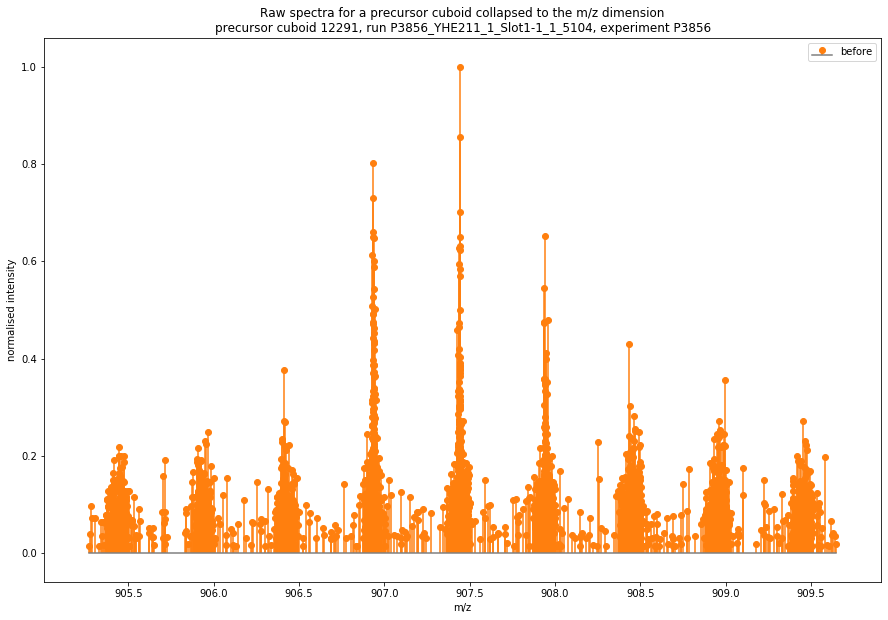

In [10]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(before_df.mz, before_df.normalised_intensity, use_line_collection=True, label='before')
plt.setp(markerline, 'color', colors[1])
plt.setp(stemlines, 'color', colors[1])
plt.setp(baseline, 'color', colors[7])

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(10)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw spectra for a precursor cuboid collapsed to the m/z dimension\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

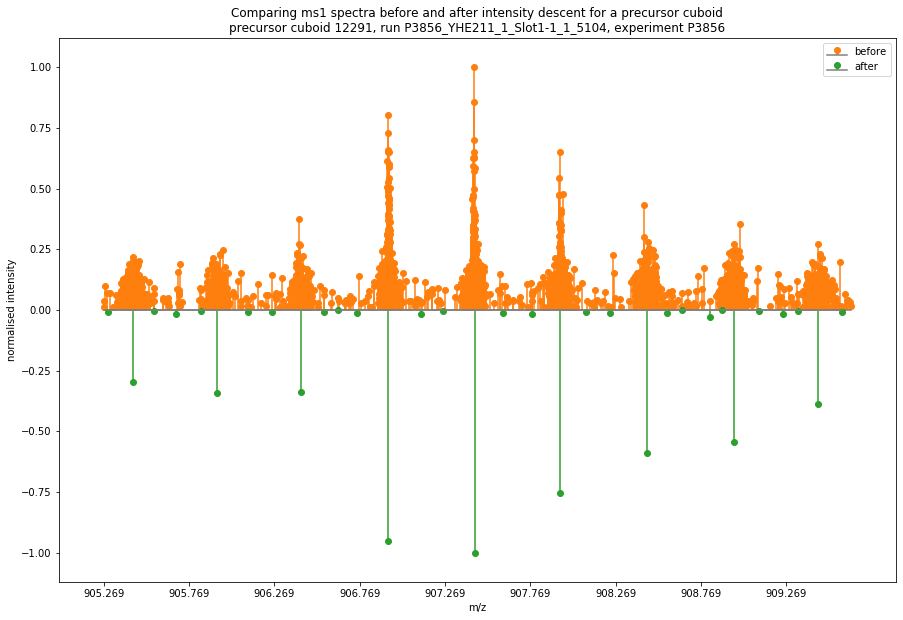

In [11]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(before_df.mz, before_df.normalised_intensity, use_line_collection=True, label='before')
plt.setp(markerline, 'color', colors[1])
plt.setp(stemlines, 'color', colors[1])
plt.setp(baseline, 'color', colors[7])

markerline, stemlines, baseline = ax.stem(after_df.mz, -after_df.normalised_intensity, use_line_collection=True, label='after')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(10)
f.set_figwidth(15)
plt.xticks(np.arange(before_df.mz.min(),before_df.mz.max(),0.5))

# plt.xlim((608.14,608.47))
# plt.ylim((-3000,3000))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Comparing ms1 spectra before and after intensity descent for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()


In [12]:
# look at the points in the region around a maximum
max_intensity_idx = before_df[(before_df.mz >= 907.269) & (before_df.mz <= 907.769)].intensity.idxmax()

In [13]:
mz_upper = before_df.loc[max_intensity_idx].mz + MS1_PEAK_DELTA
mz_lower = before_df.loc[max_intensity_idx].mz - MS1_PEAK_DELTA

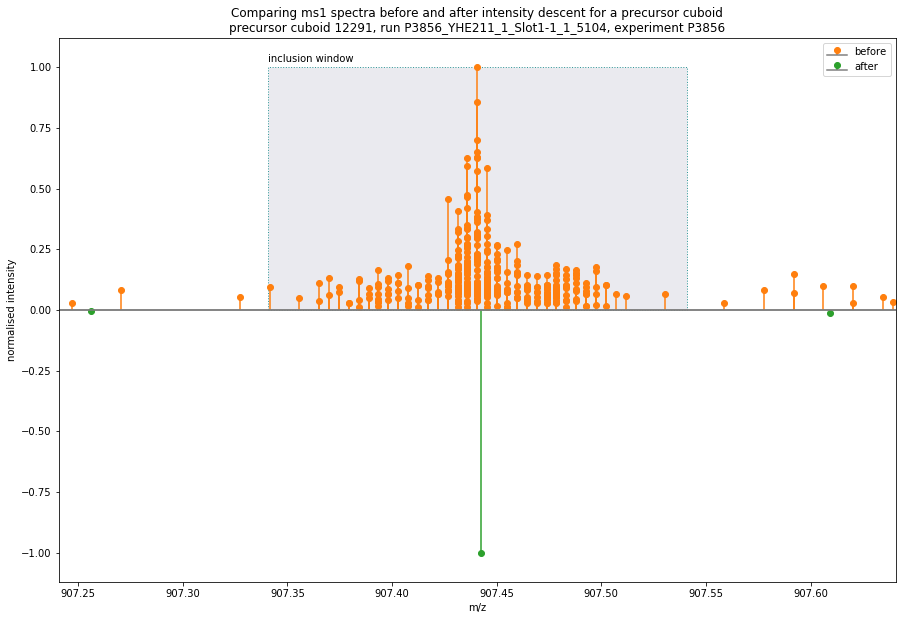

In [14]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(before_df.mz, before_df.normalised_intensity, use_line_collection=True, label='before')
plt.setp(markerline, 'color', colors[1])
plt.setp(stemlines, 'color', colors[1])
plt.setp(baseline, 'color', colors[7])

markerline, stemlines, baseline = ax.stem(after_df.mz, -after_df.normalised_intensity, use_line_collection=True, label='after')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(10)
f.set_figwidth(15)
# plt.xticks(np.arange(before_df.mz.min(),before_df.mz.max(),0.05))

plt.xlim((mz_lower-0.1,mz_upper+0.1))
# plt.ylim((-200,250))

rect = patches.Rectangle((mz_lower,0),MS1_PEAK_DELTA*2,1.0,linewidth=1,linestyle=':',edgecolor=(0.2,0.6,0.6,1.0),facecolor=(0.2,0.2,0.4,0.1),fill=True)
ax.add_patch(rect)
plt.text(mz_lower, 1.02,'inclusion window')

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Comparing ms1 spectra before and after intensity descent for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

#### features found in the cuboid with deconvolution

In [15]:
after_deconvolution_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/{}-{}-ms1-after-deconvolution-precursor-{}.csv'.format(EXPERIMENT_NAME, RUN_NAME, precursor_id))

In [16]:
after_deconvolution_df['normalised_intensity'] = after_deconvolution_df.intensity / after_deconvolution_df.intensity.max()

In [17]:
after_deconvolution_df

,monoisotopic_mz,charge,intensity,intensity_full_rt_extent,scan_apex,scan_curve_fit,scan_lower,scan_upper,rt_apex,rt_curve_fit,rt_lower,rt_upper,precursor_id,envelope,feature_id,normalised_intensity
0,906.939601,2,121945,66579,324.69,True,306.76,342.62,1709.56,True,1699.56,1719.56,12291,"[(906.9367, 35235.00), (907.4427, 37017.00), (...",1229101,1.000000
1,908.456752,2,45449,60408,333.02,True,313.02,353.02,1705.44,True,1703.41,1707.46,12291,"[(908.4530, 10996.48), (908.9599, 20122.00), (...",1229102,0.372701
2,905.431310,2,36135,32426,338.40,False,318.40,358.40,1705.77,False,1695.77,1715.77,12291,"[(905.4411, 10939.00), (905.9347, 12619.00), (...",1229103,0.296322
3,906.253226,2,988,555,343.00,False,323.00,363.00,1711.05,False,1701.05,1721.05,12291,"[(906.2579, 369.00), (906.7552, 405.00), (907....",1229104,0.008102


In [18]:
isotopes_l = []
for idx,row in enumerate(after_deconvolution_df.itertuples()):
    envelope = eval(row.envelope)
    feature_id = row.feature_id
    for isotope in envelope:
        isotopes_l.append((feature_id,)+isotope)
df = pd.DataFrame(isotopes_l, columns=['feature_id','mz','intensity'])
df['normalised_intensity'] = df.intensity / df.intensity.max()

In [19]:
df

,feature_id,mz,intensity,normalised_intensity
0,1229101,906.9367,35235.00,0.951860
1,1229101,907.4427,37017.00,1.000000
2,1229101,907.9453,27949.00,0.755031
3,1229101,908.4530,21744.00,0.587406
4,1229102,908.4530,10996.48,0.297066
5,1229102,908.9599,20122.00,0.543588
6,1229102,909.4568,14331.00,0.387146
7,1229102,909.9567,1.00,0.000027
8,1229103,905.4411,10939.00,0.295513
9,1229103,905.9347,12619.00,0.340897


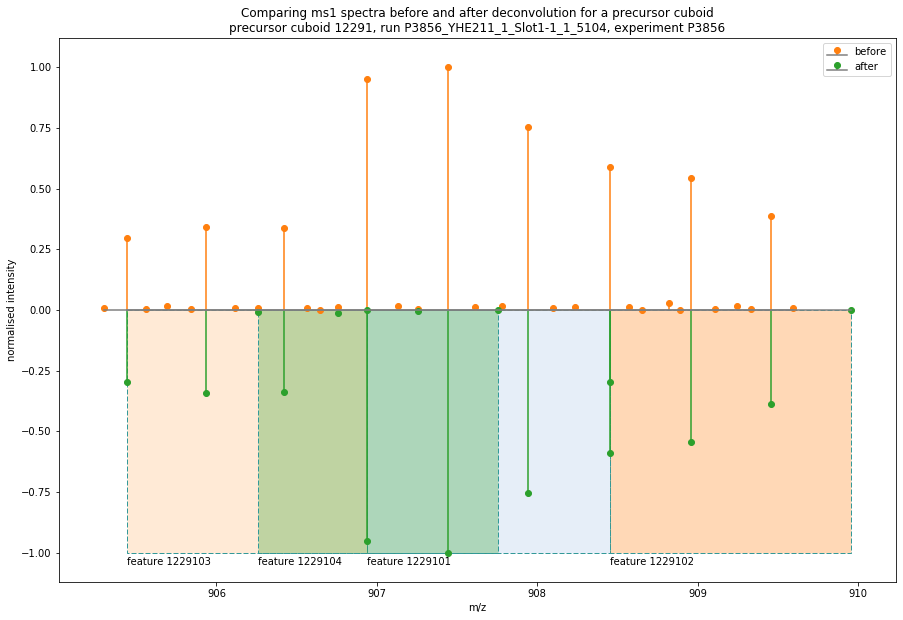

In [20]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(after_df.mz, after_df.normalised_intensity, use_line_collection=True, label='before')
plt.setp(markerline, 'color', colors[1])
plt.setp(stemlines, 'color', colors[1])
plt.setp(baseline, 'color', colors[7])

markerline, stemlines, baseline = ax.stem(df.mz, -df.normalised_intensity, use_line_collection=True, label='after')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(10)
f.set_figwidth(15)
# plt.xticks(np.arange(after_deconvolution_df.mz.min(),after_deconvolution_df.mz.max(),0.05))

# plt.xlim((608.14,608.47))
# plt.ylim((-200,250))

for idx,row in enumerate(after_deconvolution_df.itertuples()):
    envelope = eval(row.envelope)
    feature_id = row.feature_id
    env_width = envelope[-1][0] - envelope[0][0]
    rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=(0.2,0.6,0.6,1.0),facecolor=tuple(i/255. for i in tableau20[idx+1])+(0.3,),fill=True)
    ax.add_patch(rect)
    plt.text(envelope[0][0], -1.05, 'feature {}'.format(feature_id))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Comparing ms1 spectra before and after deconvolution for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

In [21]:
# the derived feature attributes
features_df[(features_df.precursor_id == precursor_id)]

,monoisotopic_mz,charge,intensity,intensity_full_rt_extent,scan_apex,scan_curve_fit,scan_lower,scan_upper,rt_apex,rt_curve_fit,rt_lower,rt_upper,precursor_id,envelope,feature_id,candidate_phr_error,mono_adjusted,original_phr_error,original_phr,monoisotopic_mass
157510,906.939601,2,121945.00000,66579,324.69,True,306.76,342.62,1709.56,True,1699.56,1719.56,12291,"((906.9367, 35235.00), (907.4427, 37017.00), (...",1229101,1.16349,False,0.0749937,1.050575,1811.864601
157511,907.954564,2,56216.41119,60408,333.02,True,313.02,353.02,1705.44,True,1703.41,1707.46,12291,"[(907.9578363766449, 10765.935644348487), (908...",1229102,0.0433846,True,0.86922,1.829859,1813.894528
157512,905.431310,2,36135.00000,32426,338.40,False,318.40,358.40,1705.77,False,1695.77,1715.77,12291,"((905.4411, 10939.00), (905.9347, 12619.00), (...",1229103,-0.120908,False,0.182387,1.153579,1808.848020
157513,906.253226,2,988.00000,555,343.00,False,323.00,363.00,1711.05,False,1701.05,1721.05,12291,"((906.2579, 369.00), (906.7552, 405.00), (907....",1229104,0.994863,False,0.123935,1.097561,1810.491853


#### only looking at one of the features that was mono-adjusted

In [22]:
feature_id = 1229103

In [23]:
# feature from deconvolution
feature_after_deconvolution = after_deconvolution_df[(after_deconvolution_df.feature_id == feature_id)].iloc[0]
feature_after_deconvolution

monoisotopic_mz                                                       905.431
charge                                                                      2
intensity                                                               36135
intensity_full_rt_extent                                                32426
scan_apex                                                               338.4
scan_curve_fit                                                          False
scan_lower                                                              318.4
scan_upper                                                              358.4
rt_apex                                                               1705.77
rt_curve_fit                                                            False
rt_lower                                                              1695.77
rt_upper                                                              1715.77
precursor_id                                                    

In [24]:
# derived feature attributes after mono adjustment checks
derived_feature_attributes = features_df[(features_df.feature_id == feature_id)].iloc[0]
derived_feature_attributes

monoisotopic_mz                                                       905.431
charge                                                                      2
intensity                                                               36135
intensity_full_rt_extent                                                32426
scan_apex                                                               338.4
scan_curve_fit                                                          False
scan_lower                                                              318.4
scan_upper                                                              358.4
rt_apex                                                               1705.77
rt_curve_fit                                                            False
rt_lower                                                              1695.77
rt_upper                                                              1715.77
precursor_id                                                    

In [25]:
adjustment_txt = 'monoisotopic peak was adjusted' if derived_feature_attributes.mono_adjusted else 'monoisotopic peak was not adjusted'

In [26]:
adjusted_envelope = derived_feature_attributes.envelope

In [27]:
expected_phr = peak_ratio(derived_feature_attributes.monoisotopic_mass, peak_number=1, number_of_sulphur=0)
expected_phr

0.9756360647532144

In [28]:
observed_phr = derived_feature_attributes.original_phr
observed_phr

1.1535789377456807

In [29]:
# note the mono is only adjusted if the candidate PHR gives a lower error _and_ it's lower than the acceptable error threshold
phr_error = abs((observed_phr - expected_phr) / expected_phr)
phr_error

0.18238652651434797

In [30]:
adjusted_phr = derived_feature_attributes.envelope[1][1] / derived_feature_attributes.envelope[0][1]
adjusted_phr

1.1535789377456807

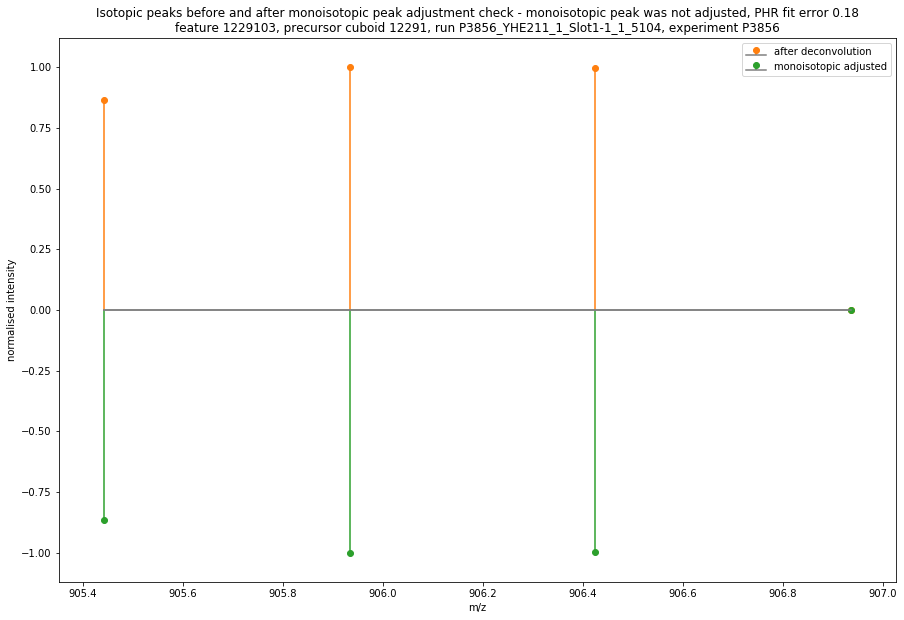

In [31]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

row = after_deconvolution_df[(after_deconvolution_df.feature_id == feature_id)].iloc[0]
envelope = eval(row.envelope)
env_width = envelope[-1][0] - envelope[0][0]

isotopes_l = []
for i in envelope:
    isotopes_l.append((i[0], i[1]))
isotopes_df = pd.DataFrame(isotopes_l, columns=['mz','intensity'])
isotopes_df['normalised_intensity'] = isotopes_df.intensity / isotopes_df.intensity.max()

adjusted_isotopes_l = []
for i in adjusted_envelope:
    adjusted_isotopes_l.append((i[0], i[1]))
adjusted_isotopes_df = pd.DataFrame(adjusted_isotopes_l, columns=['mz','intensity'])
adjusted_isotopes_df['normalised_intensity'] = adjusted_isotopes_df.intensity / adjusted_isotopes_df.intensity.max()

markerline, stemlines, baseline = ax.stem(isotopes_df.mz, isotopes_df.normalised_intensity, use_line_collection=True, label='after deconvolution')
plt.setp(markerline, 'color', colors[1])
plt.setp(stemlines, 'color', colors[1])
plt.setp(baseline, 'color', colors[7])

markerline, stemlines, baseline = ax.stem(adjusted_isotopes_df.mz, -adjusted_isotopes_df.normalised_intensity, use_line_collection=True, label='monoisotopic adjusted')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(10)
f.set_figwidth(15)
# plt.xticks(np.arange(df.mz.min(),df.mz.max(),0.5))

# plt.xlim((608.14,608.47))
# plt.ylim((-3000,3000))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Isotopic peaks before and after monoisotopic peak adjustment check - {}, PHR fit error {}\nfeature {}, precursor cuboid {}, run {}, experiment {}'.format(adjustment_txt, round(phr_error,2), feature_id, precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()